# Stationary and Non-Stationary Environments 

In the first notebook I made an short introduction on RL. I then described the famous k-armed bandit problems, environments, agents and optimal and suboptimal decision strategies when taking actions within the environment. I discussesd greedy and $\epsilon$-greedy agents and compared them. From the last two interactions of our $\epsilon$-greedy agent with the environment, we saw that with this strategy is easier to find the best action given enough time. The agent learns when to explore and when to exploit its knowledge and this balance allows to the agent to learn how to get the highest reward. 

However, there is the possibility that our agent behaves so optimally because the environment is static (it does not change), so what can we do about it?

### First load the required libraries

In [1]:
import numpy as np
import gym
import matplotlib.pyplot as plt
from tqdm import tqdm 
from gym import spaces
from gym.utils import seeding

import time 

In [2]:
%matplotlib inline

## Stationary Environemnt 
Stationary refers to the underlying behaviour of the environment. Our environment is defined by a set of actions and yields some reward. This reward, even though random, it is generated by a mean value that each action has (the true value). So even though the environment generates some random reward, every action has a true expected value that does not change. 

## Non-Stationary Environment 
How can we make an environment non-stationary? Let us take the k-armed bandit problem for example, all we have to make sure the expected true value will be changing with every interaction. However, we should be careful with the changes because no strategy would be able to deal with a completely random environment. What we want instead, is to make sure that the expected value slowly drifts away. We still want our agent to keep considering previous reward experiences in future decisions.   

For the non-stationary scenario we will use the k_armed bandit environment again, but, we will slightly change it in order to make it non-stationary. To do so, we will just apply small changes to the expected (true value) of the actions:

In [3]:
class NonStationaryBanditsEnv(gym.Env):
    
    '''Here, we get an array of length k. Each item is a function which samples 
    from a specified distribution.'''
    
    metadata = {'render.mode': ['human']}
    
    def __init__(self, m, sd, exp, nonstatic=0.1):
        
        assert len(m.shape) == 2
        assert len(sd.shape) == 2
        
        super().__init__()
        
        # define action and obs spaces
        self.mean = m.astype(np.float64)
        self.sd = sd.astype(np.float64)
        self.bandits = len(m[0]) # number of bandits 
        self.exp = exp # number of experiments 
        self.action_space = spaces.Discrete(self.bandits) # define action space
        self.obs_space = spaces.Discrete(1) # we only have 1 state in k-bandits environments
        
        self.nonstatic = nonstatic
    
    # define the step function  
    def step(self, a):
        
        # input arg: array that contains the current action 
        # output: reward array for the current action 
        
        assert (a < self.bandits).all()
        # assert self.action_space.contains(a) # assert action is valid
        
        sampled_m = self.mean[np.arange(self.exp), a]
        sampled_sd = self.sd[np.arange(self.exp), a]
        
        if self.exp == 1: # if we only have one experiment 
            r = np.random.normal(loc=sampled_m, scale=sampled_sd, size=(self.exp, self.exp,))
        else:
            r = np.random.normal(loc=sampled_m, scale=sampled_sd, size=(self.exp, ))
            
        # The non-stationary part. After an interaction we can add some noise to theenvironment's 
        # mean of true values:
        '''updated_mean = self.mean + self.nonstatic * np.random.normal(size=self.mean.shape)
        self.mean = updated_mean'''
        self.mean += self.nonstatic * np.random.normal(size=self.mean.shape)
        
        # for now return only reward 
        return r     
    
    def reset(self):
        # is reseting a desired behaviour?
        return 0
    
    def render(self, mode='human', close=False):
        pass
    
    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        
        return [seed]

class BanditsGaussian(NonStationaryBanditsEnv):
    
    '''
    This class takes the Bandids environment as an input and allows us to create an environment with random
    mean rewards for every action'''
    
    def __init__(self, exp=1, n_bandits=3, nonstationary=0.1):
        self.means = np.random.normal(size=(exp, n_bandits))
        
        NonStationaryBanditsEnv.__init__(self, self.means, np.ones((exp, n_bandits)), exp, nonstationary)

## Bulit the Agent 
We can now build the agent and test it to see  how the enviroment changes its behaviour with the **non-stationary** additions

### Argmax function

In [4]:
def argmax(mat):
    
    '''
    Input: N x k matrix with reward estimates 
    Output: array with index of the item(s) with the (first) highest value per row in the matrix 
    
    Uses the np.argmax() function with tie breaking between multiple max elements.
    
    '''
    
    # first create the template:
    template = mat == mat.max(axis=1)[:, None]
    
    # generate some random noise:
    noise = 1e-6*np.random.random(mat.shape)
    
    # multiply the noise with the template values:
    temp_n = noise * template
    
    # get the argmax of the template using the np.argmax() function. This will return only the 
    # first max element in case there are more than 1
    outmat = np.argmax(temp_n, axis=1)
    
    return outmat

def incremental_rule(aval, m, n):
    
    # aval = (previous) average value
    # m = np array with means of k-arms
    # n = step size
    
    n = n + 1 # increment step size by 1
    rewards = np.zeros(m.shape)
    
    for j in range(s):
        a = np.array([[j]])
        r = eval_env.step(a)
        rewards[0,j] = r
        
    temp = rewards[0,0]
    upd_aver = aval + 1 / n * (temp - aval)
    return upd_aver, n

### Greedy Agent

In [15]:
class GreedyAgent:
    
    def __init__(self, estimates):
        
        '''
        The Greedy Agent takes the number of experiments and bandits as input and updates the estimates of 
        the reward incrementally whenever the agent interacts with the environment
         
         INPUTS:
         estimates = np array of zeros 
        
        '''
        
        # estimates = np.zeros((e, b))
        self.exp = estimates.shape[0]
        self.bandits = estimates.shape[1]
        self.estimates = estimates.astype(np.float64) 
        self.ac = np.zeros(estimates.shape)
        
    def greedy_action(self):
        
        # we'll just use the argmax function:
        max_action = argmax(self.estimates)
        
        # if an action in self.a_count is selected (for having the highest value), add the value of 1
        self.ac[np.arange(self.exp), max_action] += 1
        
        return max_action
    
    def estimate_upd(self, r, a):
    
        '''
        Input arguments:
        r = reward,
        a = (max) actions
    
        Output: updated reward estimates 
    
        We use this function to update the reward estimates incrementally '''
    
        n = self.ac[np.arange(self.exp), a]
    
        # difference between received rewards and reward estimates 
        e = r - self.estimates[np.arange(self.exp), a]
    
        # update the reward diff incrementally
        self.estimates[np.arange(self.exp), a] += (1/n) * e

### $\epsilon$-Greedy Agent

In [16]:
class EpsilonGreedyAgent:
    
    def __init__(self, estimates, epsilon):
        
        self.exp = estimates.shape[0]
        self.bandits = estimates.shape[1]
        self.estimates = estimates.astype(np.float64) 
        self.epsilon = epsilon
        self.ac = np.zeros(estimates.shape)
        
    def new_action(self):
        
        ''' 
        This function will be similar to the greedy_action() created earlier, however, we also need to 
        account for the epsilon probability
        
        Thus, in this function we decide which actions will be greedy and which will be non-greedy. 
        '''
        # define the type of action (0 for exploration, 1 for exploitation)
        at = (np.random.random_sample(self.exp) > self.epsilon).astype(int)
        non_greedy = np.random.randint(self.bandits, size=self.exp)
        greedy = argmax(self.estimates)
        this_action = greedy * at + non_greedy * (1 - at)
        
        self.ac[np.arange(self.exp), this_action] += 1
        
        return this_action 
    
    def estimate_upd(self, r, a):
    
        '''
        Input arguments:
        r = reward,
        a = (max) actions
    
        Output: updated reward estimates 
    
        We use this function to update the reward estimates incrementally '''
    
        n = self.ac[np.arange(self.exp), a]
    
        # difference between received rewards and reward estimates 
        e = r - self.estimates[np.arange(self.exp), a]
    
        # update the reward diff incrementally
        self.estimates[np.arange(self.exp), a] += (1/n) * e

We have our environment and our agent ready. Now every time the agent interacts with the environment, the real values will change randomly just a bit. We control the amount of change when we create the environment  by adding a variable called **nonstatic**. We can now see how the environment behaves with the new changes 

In [17]:
# define initial variables
exp = 5000 # number of experiments
n_steps = 10000 # number of steps 
n_bandits = 10 # numebr of actions 
estimates = np.zeros((exp, n_bandits))
nonstationary = 0.025

# initialise variables of scrores and averages for storing and ploting:
avg = np.zeros((n_steps))
best = np.zeros((n_steps))
score = np.zeros((exp, n_steps+1))

In [18]:
# create the environment
env = BanditsGaussian(exp, n_bandits, nonstationary)
agent = GreedyAgent(estimates)

# best actions?
best_action = np.argmax(env.mean, axis=1)

In [19]:
# within a tqdm loop select actions to execute on the env 
for i in tqdm(range(n_steps)):
    max_action= agent.greedy_action()
    reward = env.step(max_action) # get reward
    
    # update the estimates with the newly obdained rewards
    agent.estimate_upd(reward, max_action)
    
    # update score, average and best variables:
    score[:,i+1] = score[:,i] + reward
    avg_score = np.mean(score[:,i+1]/(i+1))
    avg[i] = avg_score
    
    # get best actions from the env
    tmp = np.mean(max_action == best_action)
    best[i] = tmp

# store for later use   
greedy_beh = best
greedy_scores = avg

100%|██████████| 10000/10000 [00:34<00:00, 292.49it/s]


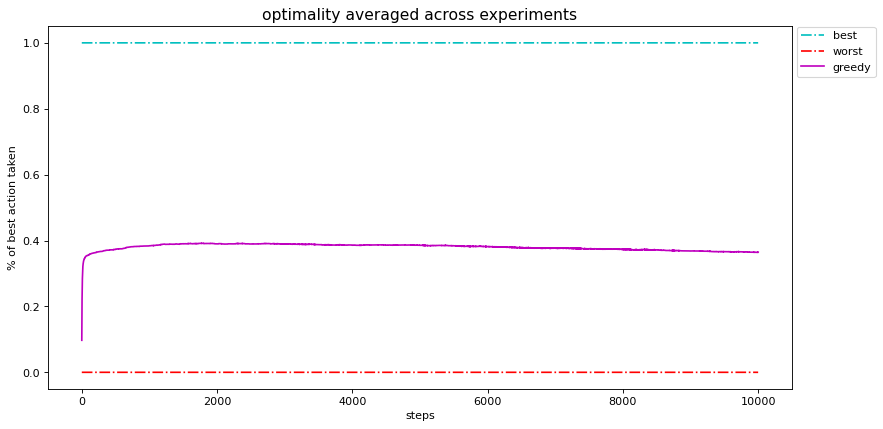

In [20]:
plt.figure(figsize=(12,6), dpi=80, facecolor='w', edgecolor='k')
plt.plot([1 for i in range(n_steps)], linestyle='-.', color='c')
plt.plot([0 for i in range(n_steps)], linestyle='-.', color='r')
plt.plot(best, color='m')
plt.legend(['best', 'worst', 'greedy'], bbox_to_anchor=(1.12, 0.93), loc='right')
plt.title('optimality averaged across experiments', fontsize=14)
plt.ylabel('% of best action taken')
plt.xlabel('steps')
plt.show()

Even though the % of times the greedy agent chooses the best action decreases in non-stationary env (~ 40% of the times), its performance over time remains constant.

We can now create and $\epsilon$-greedy  agent and let it interact with the non-stationary environment. We will then plot its progress together with the greedy agent's behaviour and compare them

In [21]:
# define initial variables
exp = 5000 # number of experiments
n_steps = 10000 # number of steps 
n_bandits = 10 # numebr of actions 
estimates = np.zeros((exp, n_bandits))
nonstationary = 0.025
epsilon = 0.1

# initialise variables of scrores and averages for storing and ploting:
avg = np.zeros((n_steps))
best = np.zeros((n_steps))
score = np.zeros((exp, n_steps+1))

In [22]:
# create the environment
env = BanditsGaussian(exp, n_bandits, nonstationary)
agent = EpsilonGreedyAgent(estimates, epsilon)

# best actions?
best_action = np.argmax(env.mean, axis=1)

In [23]:
# within a tqdm loop select actions to execute on the env 
for i in tqdm(range(n_steps)):
    max_action = agent.new_action()
    reward = env.step(max_action) # get reward
    
    # update the estimates with the newly obdained rewards
    agent.estimate_upd(reward, max_action)
    
    # update score, average and best variables:
    score[:,i+1] = score[:,i] + reward
    avg_score = np.mean(score[:,i+1]/(i+1))
    avg[i] = avg_score
    
    # get best actions from the env
    tmp = np.mean(max_action == best_action)
    best[i] = tmp

non_greedy_beh = best
non_greedy_scores = avg

100%|██████████| 10000/10000 [00:36<00:00, 277.19it/s]


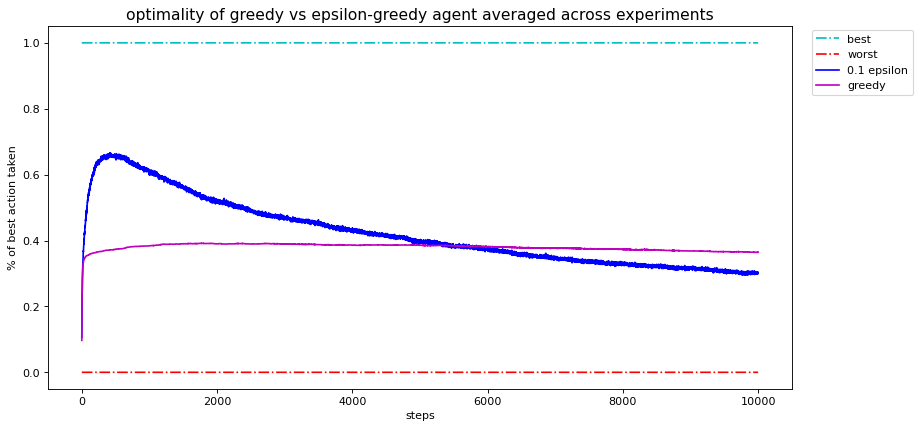

In [24]:
plt.figure(figsize=(12,6), dpi=80, facecolor='w', edgecolor='k')
plt.plot([1 for i in range(n_steps)], linestyle='-.', color='c')
plt.plot([0 for i in range(n_steps)], linestyle='-.', color='r')
plt.plot(non_greedy_beh, color='b')
plt.plot(greedy_beh, color='m')
plt.legend(['best', 'worst', '0.1 epsilon', 'greedy'], bbox_to_anchor=(1.17, 0.90), loc='right')
plt.title('optimality of greedy vs epsilon-greedy agent averaged across experiments', fontsize=14)
plt.ylabel('% of best action taken')
plt.xlabel('steps')
plt.show()

It seems that even though our $\epsilon$-greedy agent adapts to the new environment very fast, over time its performance decreases and it starts behaving worse than the greedy agent. So, what is the problem here? 
Why is the  $\epsilon$-greedy agent behaving in such sub-optimal way? And how can we change that?

This happens because of the update rule that we have added. The way it updates the estimates is designed to converge fast after a long sequence of steps. This makes sense, the more items you add to your operation the more robust your result will be. But, let us look at the incremental average update rule again:

$$n = n + 1$$

$$Q_{n} = Q_{n+1}$$

$$Q_{n}\dot{=}Q_{n-1}+\frac{1}{n} [R_{n}-Q_{n-1}]$$

The expression $\frac{1}{n}$ tells us that as $n$ gets larger, the $Q$ values change less and less (this is what helps with convergance) and this is what makes our agent decrease it's performance in the new non-stationary environment. Once enough experience is collected (and in the case of the $\epsilon$ agent this happens fast), it is very hard for the agent to adapt to a dynamic environment that changes constantly. 

We can handle this problem by modifying the incremental update rule.
Generally, for a model to learn we use the ***error*** or ***loss function*** which  tells us how far our estimated values are from the true values. A loss function maps decisions to their associated costs. To improve our model we need to update its parameters. But how much should we change the parameters? This is defined by the ***learning rate*** of the model. 

In other words, we need to optimise our agent to be able to adapt easily in the new changing environment, and to do so, we use the **Gradient Descent Rule**: 

$$\theta\colon{=}\theta - \alpha[h(x)-y]$$

$\alpha$ is the learning rate. This simplified version of the gradient descent update rule is very similar to our incremental average update rule. We just need to change the $\frac{1}{n}$ expression that helps with convergence with the learning rate: 

$$Q_{n}\dot{=}Q_{n-1}+\alpha [R_{n}-Q_{n-1}]$$

Using the constant $\alpha$ is a simple and effective way of controlling the above problem. We can now build our new agent optimised to adapt in non-stationary environments. We will define the step-size we want to implement while builtding a new agent:

In [25]:
class OptimalEpsilonAgent:
    
    ''' 
    This version of epsilon-greedy agent takes a constant step-size parameter alpha 
    '''
    def __init__(self, estimates, epslion):
        
        self.exp = estimates.shape[0]
        self.bandits = estimates.shape[1]
        self.estimates = estimates.astype(np.float64) 
        self.epsilon = epsilon
        self.ac = np.zeros(estimates.shape)
        
        alpha_param = lambda n: 0.1
        self.ap = alpha_param
        
    def new_action(self):
        
        ''' 
        This function will be similar to the greedy_action() created earlier, however, we also need to 
        account for the epsilon probability
        
        Thus, in this function we decide which actions will be greedy and which will be non-greedy. 
        '''
        # define the type of action (0 for exploration, 1 for exploitation)
        at = (np.random.random_sample(self.exp) > self.epsilon).astype(int)
        non_greedy = np.random.randint(self.bandits, size=self.exp)
        greedy = argmax(self.estimates)
        this_action = greedy * at + non_greedy * (1 - at)
        
        self.ac[np.arange(self.exp), this_action] += 1
        
        return this_action 
        
    '''
    Now let's make the new function for updating our estimated values'''
    
    def update_rule(self, r, a):
        
        '''
        r = reward matrix obtained from previous interactions
        a = chosen action, used to update the estimates
        '''
        
        n = self.ac[np.arange(self.exp), a]
        e = r - self.estimates[np.arange(self.exp), a] # compute error
        ap = self.ap(n) # consider the alpha rate 
        self.estimates[np.arange(self.exp), a] += ap * e

No we control for how much $\alpha$ should update our estimates in each interaction. We use a small contant to allow the agent to learn and adapt. 

In [26]:
# define initial variables
exp = 5000 # number of experiments
n_steps = 10000 # number of steps 
n_bandits = 10 # numebr of actions 
estimates = np.zeros((exp, n_bandits))
nonstationary = 0.025
epsilon = 0.1

# initialise variables of scrores and averages for storing and ploting:
avg = np.zeros((n_steps))
best = np.zeros((n_steps))
score = np.zeros((exp, n_steps+1))

In [27]:
# create the environment
env = BanditsGaussian(exp, n_bandits, nonstationary)
agent = OptimalEpsilonAgent(estimates, epsilon)

# best actions?
best_action = np.argmax(env.mean, axis=1)

In [28]:
# within a tqdm loop select actions to execute on the env 
for i in tqdm(range(n_steps)):
    max_action = agent.new_action()
    reward = env.step(max_action) # get reward
    
    # update the estimates with the newly obdained rewards
    agent.update_rule(reward, max_action) # we use the new general update rule 
    
    # update score, average and best variables:
    score[:,i+1] = score[:,i] + reward
    avg_score = np.mean(score[:,i+1]/(i+1))
    avg[i] = avg_score
    
    # get best actions from the env
    tmp = np.mean(max_action == best_action)
    best[i] = tmp

optimal_beh = best
optimal_scores = avg

100%|██████████| 10000/10000 [00:38<00:00, 260.61it/s]


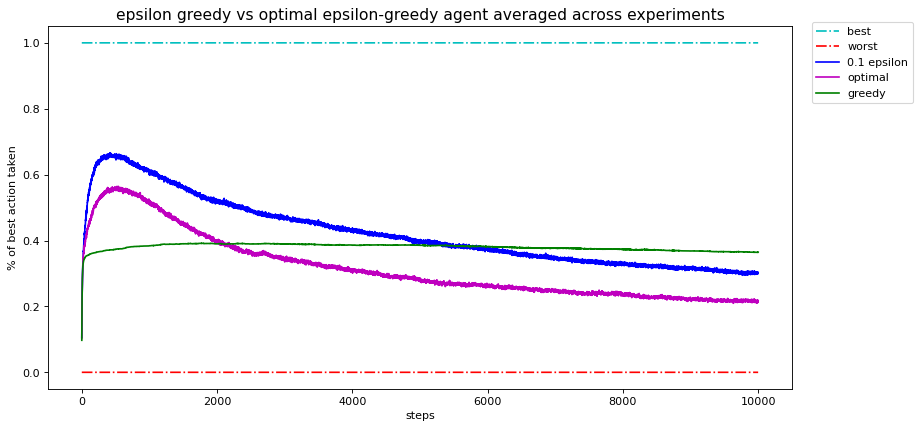

In [29]:
plt.figure(figsize=(12,6), dpi=80, facecolor='w', edgecolor='k')
plt.plot([1 for i in range(n_steps)], linestyle='-.', color='c')
plt.plot([0 for i in range(n_steps)], linestyle='-.', color='r')
plt.plot(non_greedy_beh, color='b')
plt.plot(optimal_beh, color='m')
plt.plot(greedy_beh, color='g')
plt.legend(['best', 'worst', '0.1 epsilon', 'optimal', 'greedy'], bbox_to_anchor=(1.17, 0.90), loc='right')
plt.title('epsilon greedy vs optimal epsilon-greedy agent averaged across experiments', fontsize=14)
plt.ylabel('% of best action taken')
plt.xlabel('steps')
plt.show()